<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-pytorch/blob/master/8-using-convolutions-to-generalize/1_convolutions_in_action.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using convolutions to generalize

Due to the fully connected setup needed to detect the various possible translations of the bird or airplane in the image, we have both too many parameters (making it easier for the model to memorize the training set) and no position independence (making it harder to generalize). 

As we know, we could augment our training data by using a wide variety of recropped images to try to force generalization, but that won’t address the issue of having too many parameters.
**There is a better way! It consists of replacing the dense, fully connected affine transformation in our neural network unit with a different linear operation: convolution.**


## Setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

%matplotlib inline

In [2]:
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

## The case for convolutions

We know that taking a 1D view of our input image and multiplying it by an
n_output_features × n_input_features weight matrix, as is done in nn.Linear,
means for each channel in the image, computing a weighted sum of all the pixels multiplied by a set of weights, one per output feature.

In [5]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [6]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [7]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [8]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [9]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In order to translate this intuition into mathematical form, we could compute the weighted sum of a pixel with its immediate neighbors, rather than with all other pixels in the image. This would be equivalent to building weight matrices, one per output feature and output pixel location, in which all weights beyond a certain distance from a center pixel are zero. This will still be a weighted sum: that is, a linear operation.

## What convolutions do

We identified one more desired property earlier: we would like these localized patterns to have an effect on the output regardless of their location in the image: that is, to be translation invariant.

**Fortunately, there is a readily available, local, translation-invariant linear operation on the image: a convolution.**

**Convolution, or more precisely, discrete convolution is defined for a 2D image as the scalar product of a weight matrix, the kernel, with every neighborhood in the input.**

Consider a 3 × 3 kernel (in deep learning, we typically use small kernels; we’ll see why later on) as a 2D tensor.

```python
weight = torch.tensor([
  [w00, w01, w02],
  [w10, w11, w12],
  [w20, w21, w22]
])
```

and a 1-channel, MxN image:

```python
image = torch.tensor([
  [i00, i01, i02, i03, ..., i0N],
  [i10, i11, i12, i13, ..., i1N],
  [i20, i21, i22, i23, ..., i2N],
  [i30, i31, i32, i33, ..., i3N],
  ...
  [iM0, iM1m iM2, iM3, ..., iMN]
])
```

We can compute an element of the output image (without bias) as follows:

```python
o11 = i11 * w00 + i12 * w01 + i22 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22
```

That is, we “translate” the kernel on the i11 location of the input image, and we multiply each weight by the value of the input image at the corresponding location. Thus, the output image is created by translating the kernel on all input locations and performing the weighted sum. For a multichannel image, like our RGB image, the weight matrix would be a 3 × 3 × 3 matrix: one set of weights for every channel, contributing together to the output values.

Note that, just like the elements in the weight matrix of nn.Linear, the weights in the kernel are not known in advance, but they are initialized randomly and updated through backpropagation. Note also that the same kernel, and thus each weight in the kernel, is reused across the whole image. Thinking back to autograd, this means the use of each weight has a history spanning the entire image. Thus, the derivative of the loss with respect to a convolution weight includes contributions from the entire image.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-pytorch/locality-and-translation-invariance.png?raw=1' width='800'/>

It’s now possible to see the connection to what we were stating earlier:**a convolution is equivalent to having multiple linear operations whose weights are zero almost everywhere except around individual pixels and that receive equal updates during training.**

Summarizing, by switching to convolutions, we get:

- **Local operations on neighborhoods**
- **Local operations on neighborhoods**
- **Models with a lot fewer parameters**

The key insight underlying the third point is that, with a convolution layer, the number of parameters depends not on the number of pixels in the image, as was the case in our fully connected model, but rather on the size of the convolution kernel (3 × 3, 5 × 5, and so on) and on how many convolution filters (or output channels) we decide to use in our model.

## Convolutions in action

Let’s see some PyTorch in action on our birds versus airplanes challenge. The torch.nn module provides convolutions for 1, 2, and 3 dimensions: nn.Conv1d for time series, nn.Conv2d for images, and nn.Conv3d for volumes or videos.

At a minimum, the arguments we provide to nn.Conv2d are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output features, and the size of the kernel.

The more channels in the output image, the more the capacity of the network. We need the channels to be able to detect many different types of features.

It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever kernel_size=3 is specified for a 2D convolution, it means 3 × 3 (provided as a tuple (3, 3) in Python). For a 3D convolution, it means 3 × 3 × 3.

In [10]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? 

The kernel is of size `3 × 3`, so we want the weight to consist of `3 × 3` parts. For a single output pixel value, our kernel would consider, say, `in_ch = 3` input channels, so the weight component for a single output pixel value (and by translation the invariance for the entire output channel) is of shape `in_ch × 3 × 3`. Finally, we have as many of those as we have output channels, here `out_ch = 16`, so the complete weight tensor is `out_ch × in_ch × 3 × 3`, in our case `16 × 3 × 3 × 3`. The bias will have size 16.

Let’s verify our assumptions:

In [11]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

We can see how convolutions are a convenient choice for learning from images. We
have smaller models looking for local patterns whose weights are optimized across the entire image.

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image.

As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a B × C × H × W shaped tensor as input:

In [12]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We’re curious, so we can display the output.

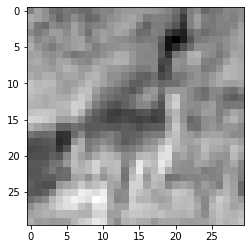

In [13]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

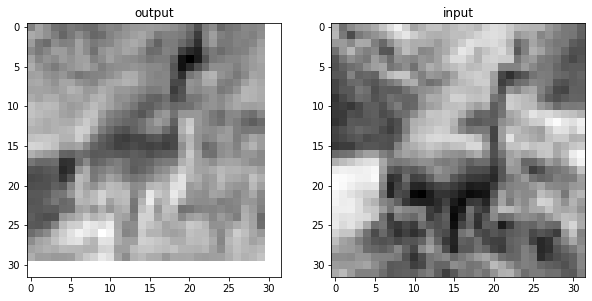

In [14]:
plt.figure(figsize=(10, 4.8)) 
ax1 = plt.subplot(1, 2, 1)   
plt.title('output')   
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1) 
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input')  
 
plt.show()

Wait a minute. Let’s take a look a the size of output: it’s `torch.Size([1, 16, 30, 30])`. Huh; we lost a few pixels in the process. How did that happen?

## Padding the boundary

By default, PyTorch will slide the convolution kernel within the input picture, getting `width - kernel_width + 1` horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, 3//2 = 1) smaller on each side. This explains why we’re missing two pixels in each dimension.

However, PyTorch gives us the possibility of padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-pytorch/zero-padding.png?raw=1' width='800'/>

In our case, specifying padding=1 when kernel_size=3 means i00 has an extra set
of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image.

In [15]:
# Now with padding
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

There are two main reasons to pad convolutions. 

First, doing so helps us separate the matters of convolution and changing image sizes, so we have one less thing to remember. 

And second, when we have more elaborate structures such as skip connections or the U-Nets we’ll cover in part 2, we want the tensors before and after a few convolutions to be of compatible size so that we can add them or take differences.

## Detecting features with convolutions